In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torch.utils.data.dataloader import DataLoader, Dataset
from torchvision.io import decode_image
from torchvision.transforms import Resize
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_float32_matmul_precision('medium')

# Constants for converting lat/lon to meters (approximate)
METERS_PER_DEG_LAT = 111_000  # ~111 km per degree latitude
METERS_PER_DEG_LON = 86_500   # ~86.5 km per degree longitude (varies with latitude)

def euclidean_distance_meters(pred_lat, pred_lon, true_lat, true_lon):
    """Calculate approximate Euclidean distance in meters between coordinates."""
    dlat_m = (pred_lat - true_lat) * METERS_PER_DEG_LAT
    dlon_m = (pred_lon - true_lon) * METERS_PER_DEG_LON
    return torch.sqrt(dlat_m**2 + dlon_m**2)

In [2]:
class GlobalStreetscapesRegression(Dataset):
    def __init__(self, dataset, lat_mean, lat_std, lon_mean, lon_std):
        self.img_labels = dataset
        self.resize = Resize(size=(224, 224))
        # Store normalization parameters
        self.lat_mean = lat_mean
        self.lat_std = lat_std
        self.lon_mean = lon_mean
        self.lon_std = lon_std

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join("../../", self.img_labels.iloc[idx].loc["path"])
        image = decode_image(img_path, apply_exif_orientation=True)
        image = self.resize(image)
        
        # Get coordinates and normalize them
        lat = self.img_labels.iloc[idx].loc["lat"]
        lon = self.img_labels.iloc[idx].loc["lon"]
        
        # Normalize coordinates (important for regression stability)
        lat_norm = (lat - self.lat_mean) / self.lat_std
        lon_norm = (lon - self.lon_mean) / self.lon_std
        
        coords = torch.tensor([lat_norm, lon_norm], dtype=torch.float32)
        return image, coords

In [3]:
samples = pd.read_csv('../../../data/imgs/sampled.csv', index_col=0)
paths = pd.read_csv('../../../data/img_paths.csv', index_col=0)
img_labels = samples.join(paths, on='uuid', how='inner')

print("samples rows:", samples.shape[0])
print("paths rows:", paths.shape[0])
print("img_labels rows:", img_labels.shape[0])

# Calculate normalization parameters from full dataset BEFORE splitting
lat_mean = img_labels['lat'].mean()
lat_std = img_labels['lat'].std()
lon_mean = img_labels['lon'].mean()
lon_std = img_labels['lon'].std()

print(f"\nCoordinate statistics:")
print(f"Lat - Mean: {lat_mean:.6f}, Std: {lat_std:.6f}")
print(f"Lon - Mean: {lon_mean:.6f}, Std: {lon_std:.6f}")

# Store normalization params for later use
norm_params = {
    'lat_mean': lat_mean,
    'lat_std': lat_std,
    'lon_mean': lon_mean,
    'lon_std': lon_std
}

train_ratio = 0.8
train_df, test_df = train_test_split(img_labels, train_size=train_ratio, random_state=42)

display(train_df.head())

training_data = GlobalStreetscapesRegression(
    train_df, lat_mean, lat_std, lon_mean, lon_std
)

test_data = GlobalStreetscapesRegression(
    test_df, lat_mean, lat_std, lon_mean, lon_std
)

# Use num_workers for parallel data loading and pin_memory for faster GPU transfer
train_dataloader = DataLoader(training_data, batch_size=256, shuffle=True, num_workers=16, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=256, shuffle=True, num_workers=16, pin_memory=True)

samples rows: 190693
paths rows: 200660
img_labels rows: 190693

Coordinate statistics:
Lat - Mean: 38.900114, Std: 0.004847
Lon - Mean: -77.025562, Std: 0.006267


,uuid,source,orig_id,city,country,iso3,s2_cell_id,lat,lon,label,path
74756,c9ce89cc-6d01-4943-9db6-f4b26a335719,Mapillary,1069937113654899,Washington,United States,USA,9923602156437907749,38.903819,-77.032014,71,../data/imgs/6161da57-bd9d-440d-8ccc-c3712f616...
59508,893acdb0-da01-41be-ab94-57d9b24f30a4,Mapillary,760546458541060,Washington,United States,USA,9923602161699702581,38.899841,-77.027891,44,../data/imgs/b2826172-2d6e-414e-a1fd-9e7fbc4d6...
133680,336c47d8-6c12-4985-9eac-1912a1f73d49,Mapillary,2791414084503334,Washington,United States,USA,9923602565273983939,38.904975,-77.015465,89,../data/imgs/39c495d2-87e0-44e1-8221-550c3a4e5...
65838,c3ed6d53-d219-450e-b020-c960b093ceb7,Mapillary,1047301562591781,Washington,United States,USA,9923602091769756403,38.891493,-77.015185,9,../data/imgs/197d5634-2535-4114-be03-562f54b2a...
132102,ecb32e7a-cde8-4452-bde0-0ed232fb3b52,Mapillary,1117647205851454,Washington,United States,USA,9923602341117112595,38.906771,-77.034994,90,../data/imgs/39c495d2-87e0-44e1-8221-550c3a4e5...


City: Washington
Coordinates: (38.899802, -77.023114)


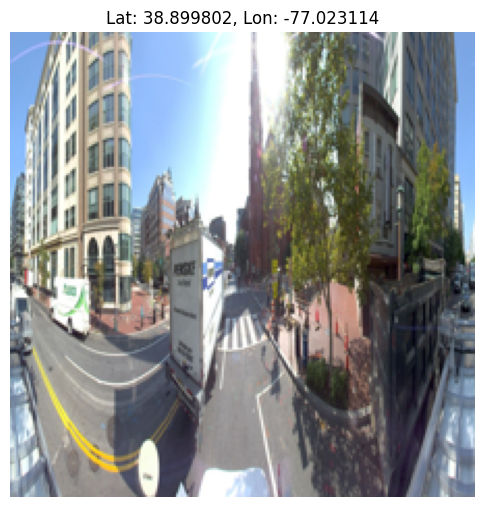

In [4]:
p = os.path.join("../../", training_data.img_labels.iloc[10].loc["path"])
lat = training_data.img_labels.iloc[10].loc["lat"]
lon = training_data.img_labels.iloc[10].loc["lon"]
print(f"City: {training_data.img_labels.iloc[10].loc['city']}")
print(f"Coordinates: ({lat:.6f}, {lon:.6f})")

img = Image.open(p).convert("RGB")
img = img.resize((224, 224))
plt.figure(figsize=(6, 10))
plt.imshow(img)
plt.title(f"Lat: {lat:.6f}, Lon: {lon:.6f}")
plt.axis("off")
plt.show()

In [5]:
# Base Vision Transformer Docs: https://github.com/pytorch/vision/blob/main/torchvision/models/vision_transformer.py
# VIT_B_16 Docs: https://docs.pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html
weights = ViT_B_16_Weights.IMAGENET1K_V1
transform = weights.transforms()

model = vit_b_16(weights=weights)

in_features = model.heads.head.in_features

# Replace the classification head with a regression head (2 outputs: lat, lon)
print(f"Previous head: {model.heads.head}")
model.heads.head = nn.Sequential(
    nn.Linear(in_features=in_features, out_features=256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(in_features=256, out_features=2)  # 2 outputs: lat, lon
)
print(f"New head: {model.heads.head}")

model = model.to(device=device)
model = torch.compile(model)
print(f"Using device: {device}")

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:00<00:00, 412MB/s] 


Previous head: Linear(in_features=768, out_features=1000, bias=True)
New head: Sequential(
  (0): Linear(in_features=768, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=256, out_features=2, bias=True)
)
Using device: cuda


In [6]:
num_epochs = 20
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)
criterion = nn.MSELoss()  # MSE loss for regression

# Keep OneCycleLR with 10% warmup (same as original)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-4,
    steps_per_epoch=len(train_dataloader),
    epochs=num_epochs,
    pct_start=0.1  # 10% of total steps used for warmup
)

# Track metrics
train_losses = []
val_losses = []
val_distances = []

for epoch in range(num_epochs):
    print(f"EPOCH: {epoch+1}")

    # Training phase
    current_loss = 0
    model.train()
    for inputs, coords in tqdm(train_dataloader):
        # Move to GPU with non_blocking for better performance
        inputs = inputs.to(device, non_blocking=True)
        coords = coords.to(device, non_blocking=True)
        
        inputs = transform(inputs)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, coords)
        loss.backward()
        optimizer.step()
        scheduler.step()  # Moved inside the batch loop for OneCycleLR
        
        current_loss += loss.item()
    
    avg_train_loss = current_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Train MSE Loss: {avg_train_loss:.6f}")
    print(f"LR: {scheduler.get_last_lr()[0]:.6f}")
    
    # Validation phase
    model.eval()
    val_loss = 0
    total_distance = 0
    num_samples = 0
    
    with torch.no_grad():
        for inputs, coords in tqdm(test_dataloader, desc="Validating", leave=False):
            inputs = inputs.to(device, non_blocking=True)
            coords = coords.to(device, non_blocking=True)
            
            inputs = transform(inputs)
            outputs = model(inputs)
            
            loss = criterion(outputs, coords)
            val_loss += loss.item()
            
            # Denormalize for distance calculation
            pred_lat = outputs[:, 0] * norm_params['lat_std'] + norm_params['lat_mean']
            pred_lon = outputs[:, 1] * norm_params['lon_std'] + norm_params['lon_mean']
            true_lat = coords[:, 0] * norm_params['lat_std'] + norm_params['lat_mean']
            true_lon = coords[:, 1] * norm_params['lon_std'] + norm_params['lon_mean']
            
            distances = euclidean_distance_meters(pred_lat, pred_lon, true_lat, true_lon)
            total_distance += distances.sum().item()
            num_samples += coords.size(0)
    
    avg_val_loss = val_loss / len(test_dataloader)
    avg_distance = total_distance / num_samples
    val_losses.append(avg_val_loss)
    val_distances.append(avg_distance)
    
    print(f"Val MSE Loss: {avg_val_loss:.6f}")
    print(f"Val Mean Distance Error: {avg_distance:.2f} meters")
    
    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'val_distance': avg_distance,
        'norm_params': norm_params,
    }, f'vit_b_16_regression_epoch{epoch}.pth')

EPOCH: 1


  0%|          | 0/596 [00:00<?, ?it/s]

Train MSE Loss: 0.553705
LR: 0.000052


Validating:   0%|          | 0/149 [00:00<?, ?it/s]

Val MSE Loss: 0.341603
Val Mean Distance Error: 358.95 meters
EPOCH: 2


  0%|          | 0/596 [00:00<?, ?it/s]

Train MSE Loss: 0.282172
LR: 0.000100


Validating:   0%|          | 0/149 [00:00<?, ?it/s]

Val MSE Loss: 0.265031
Val Mean Distance Error: 293.29 meters
EPOCH: 3


  0%|          | 0/596 [00:00<?, ?it/s]

Train MSE Loss: 0.197478
LR: 0.000099


Validating:   0%|          | 0/149 [00:00<?, ?it/s]

Val MSE Loss: 0.207223
Val Mean Distance Error: 250.68 meters
EPOCH: 4


  0%|          | 0/596 [00:00<?, ?it/s]

Train MSE Loss: 0.160207
LR: 0.000097


Validating:   0%|          | 0/149 [00:00<?, ?it/s]

Val MSE Loss: 0.229917
Val Mean Distance Error: 259.13 meters
EPOCH: 5


  0%|          | 0/596 [00:00<?, ?it/s]

Train MSE Loss: 0.129646
LR: 0.000093


Validating:   0%|          | 0/149 [00:00<?, ?it/s]

Val MSE Loss: 0.184942
Val Mean Distance Error: 220.53 meters
EPOCH: 6


  0%|          | 0/596 [00:00<?, ?it/s]

Train MSE Loss: 0.092996
LR: 0.000088


Validating:   0%|          | 0/149 [00:00<?, ?it/s]

Val MSE Loss: 0.179025
Val Mean Distance Error: 226.86 meters
EPOCH: 7


  0%|          | 0/596 [00:00<?, ?it/s]

Train MSE Loss: 0.082946
LR: 0.000082


Validating:   0%|          | 0/149 [00:00<?, ?it/s]

Val MSE Loss: 0.143294
Val Mean Distance Error: 183.62 meters
EPOCH: 8


  0%|          | 0/596 [00:00<?, ?it/s]

Train MSE Loss: 0.046782
LR: 0.000075


Validating:   0%|          | 0/149 [00:00<?, ?it/s]

Val MSE Loss: 0.142336
Val Mean Distance Error: 176.02 meters
EPOCH: 9


  0%|          | 0/596 [00:00<?, ?it/s]

Train MSE Loss: 0.031189
LR: 0.000067


Validating:   0%|          | 0/149 [00:00<?, ?it/s]

Val MSE Loss: 0.127600
Val Mean Distance Error: 161.94 meters
EPOCH: 10


  0%|          | 0/596 [00:00<?, ?it/s]

Train MSE Loss: 0.022139
LR: 0.000059


Validating:   0%|          | 0/149 [00:00<?, ?it/s]

Val MSE Loss: 0.121824
Val Mean Distance Error: 155.25 meters
EPOCH: 11


  0%|          | 0/596 [00:00<?, ?it/s]

Train MSE Loss: 0.016221
LR: 0.000050


Validating:   0%|          | 0/149 [00:00<?, ?it/s]

Val MSE Loss: 0.115297
Val Mean Distance Error: 149.32 meters
EPOCH: 12


  0%|          | 0/596 [00:00<?, ?it/s]

Train MSE Loss: 0.012256
LR: 0.000041


Validating:   0%|          | 0/149 [00:00<?, ?it/s]

Val MSE Loss: 0.112750
Val Mean Distance Error: 145.63 meters
EPOCH: 13


  0%|          | 0/596 [00:00<?, ?it/s]

Train MSE Loss: 0.009512
LR: 0.000033


Validating:   0%|          | 0/149 [00:00<?, ?it/s]

Val MSE Loss: 0.108951
Val Mean Distance Error: 142.38 meters
EPOCH: 14


  0%|          | 0/596 [00:00<?, ?it/s]

Train MSE Loss: 0.007445
LR: 0.000025


Validating:   0%|          | 0/149 [00:00<?, ?it/s]

Val MSE Loss: 0.107881
Val Mean Distance Error: 140.16 meters
EPOCH: 15


  0%|          | 0/596 [00:00<?, ?it/s]

Train MSE Loss: 0.005985
LR: 0.000018


Validating:   0%|          | 0/149 [00:00<?, ?it/s]

Val MSE Loss: 0.106290
Val Mean Distance Error: 138.25 meters
EPOCH: 16


  0%|          | 0/596 [00:00<?, ?it/s]

Train MSE Loss: 0.004924
LR: 0.000012


Validating:   0%|          | 0/149 [00:00<?, ?it/s]

Val MSE Loss: 0.105605
Val Mean Distance Error: 137.32 meters
EPOCH: 17


  0%|          | 0/596 [00:00<?, ?it/s]

Train MSE Loss: 0.004245
LR: 0.000007


Validating:   0%|          | 0/149 [00:00<?, ?it/s]

Val MSE Loss: 0.105112
Val Mean Distance Error: 136.34 meters
EPOCH: 18


  0%|          | 0/596 [00:00<?, ?it/s]

Train MSE Loss: 0.003790
LR: 0.000003


Validating:   0%|          | 0/149 [00:00<?, ?it/s]

Val MSE Loss: 0.105030
Val Mean Distance Error: 135.84 meters
EPOCH: 19


  0%|          | 0/596 [00:00<?, ?it/s]

Train MSE Loss: 0.003520
LR: 0.000001


Validating:   0%|          | 0/149 [00:00<?, ?it/s]

Val MSE Loss: 0.104748
Val Mean Distance Error: 135.63 meters
EPOCH: 20


  0%|          | 0/596 [00:00<?, ?it/s]

Train MSE Loss: 0.003401
LR: 0.000000


Validating:   0%|          | 0/149 [00:00<?, ?it/s]

Val MSE Loss: 0.104746
Val Mean Distance Error: 135.48 meters


In [7]:
# Final Evaluation
model.eval()
all_distances = []
all_predictions = []
all_targets = []
all_losses = []

with torch.no_grad():
    for inputs, coords in tqdm(test_dataloader, desc="Final Evaluation"):
        inputs = inputs.to(device, non_blocking=True)
        coords = coords.to(device, non_blocking=True)

        inputs = transform(inputs)
        outputs = model(inputs)
        
        # Calculate per-sample MSE loss (on normalized coords)
        sample_losses = ((outputs - coords) ** 2).mean(dim=1)
        all_losses.extend(sample_losses.cpu().numpy())
        
        # Denormalize predictions and targets
        pred_lat = outputs[:, 0] * norm_params['lat_std'] + norm_params['lat_mean']
        pred_lon = outputs[:, 1] * norm_params['lon_std'] + norm_params['lon_mean']
        true_lat = coords[:, 0] * norm_params['lat_std'] + norm_params['lat_mean']
        true_lon = coords[:, 1] * norm_params['lon_std'] + norm_params['lon_mean']
        
        distances = euclidean_distance_meters(pred_lat, pred_lon, true_lat, true_lon)
        all_distances.extend(distances.cpu().numpy())
        
        # Store for visualization
        all_predictions.extend(torch.stack([pred_lat, pred_lon], dim=1).cpu().numpy())
        all_targets.extend(torch.stack([true_lat, true_lon], dim=1).cpu().numpy())

all_distances = np.array(all_distances)
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)
all_losses = np.array(all_losses)

# Calculate distance metrics
mean_distance = np.mean(all_distances)
median_distance = np.median(all_distances)
std_distance = np.std(all_distances)
percentile_25_dist = np.percentile(all_distances, 25)
percentile_75_dist = np.percentile(all_distances, 75)
percentile_90_dist = np.percentile(all_distances, 90)

# Calculate loss metrics
mean_loss = np.mean(all_losses)
median_loss = np.median(all_losses)

print("=" * 60)
print("FINAL TEST RESULTS")
print("=" * 60)
print("\n--- Distance Error Metrics ---")
print(f"Mean Distance Error: {mean_distance:.2f} meters")
print(f"Median Distance Error: {median_distance:.2f} meters")
print(f"Std Distance Error: {std_distance:.2f} meters")
print(f"25th Percentile: {percentile_25_dist:.2f} meters")
print(f"75th Percentile: {percentile_75_dist:.2f} meters")
print(f"90th Percentile: {percentile_90_dist:.2f} meters")
print(f"Min Distance Error: {np.min(all_distances):.2f} meters")
print(f"Max Distance Error: {np.max(all_distances):.2f} meters")

print("\n--- MSE Loss Metrics ---")
print(f"Mean MSE Loss: {mean_loss:.6f}")
print(f"Median MSE Loss: {median_loss:.6f}")

Final Evaluation:   0%|          | 0/149 [00:00<?, ?it/s]

FINAL TEST RESULTS

--- Distance Error Metrics ---
Mean Distance Error: 135.48 meters
Median Distance Error: 52.90 meters
Std Distance Error: 206.79 meters
25th Percentile: 26.04 meters
75th Percentile: 141.86 meters
90th Percentile: 375.33 meters
Min Distance Error: 0.42 meters
Max Distance Error: 1941.53 meters

--- MSE Loss Metrics ---
Mean MSE Loss: 0.104745
Median MSE Loss: 0.004795


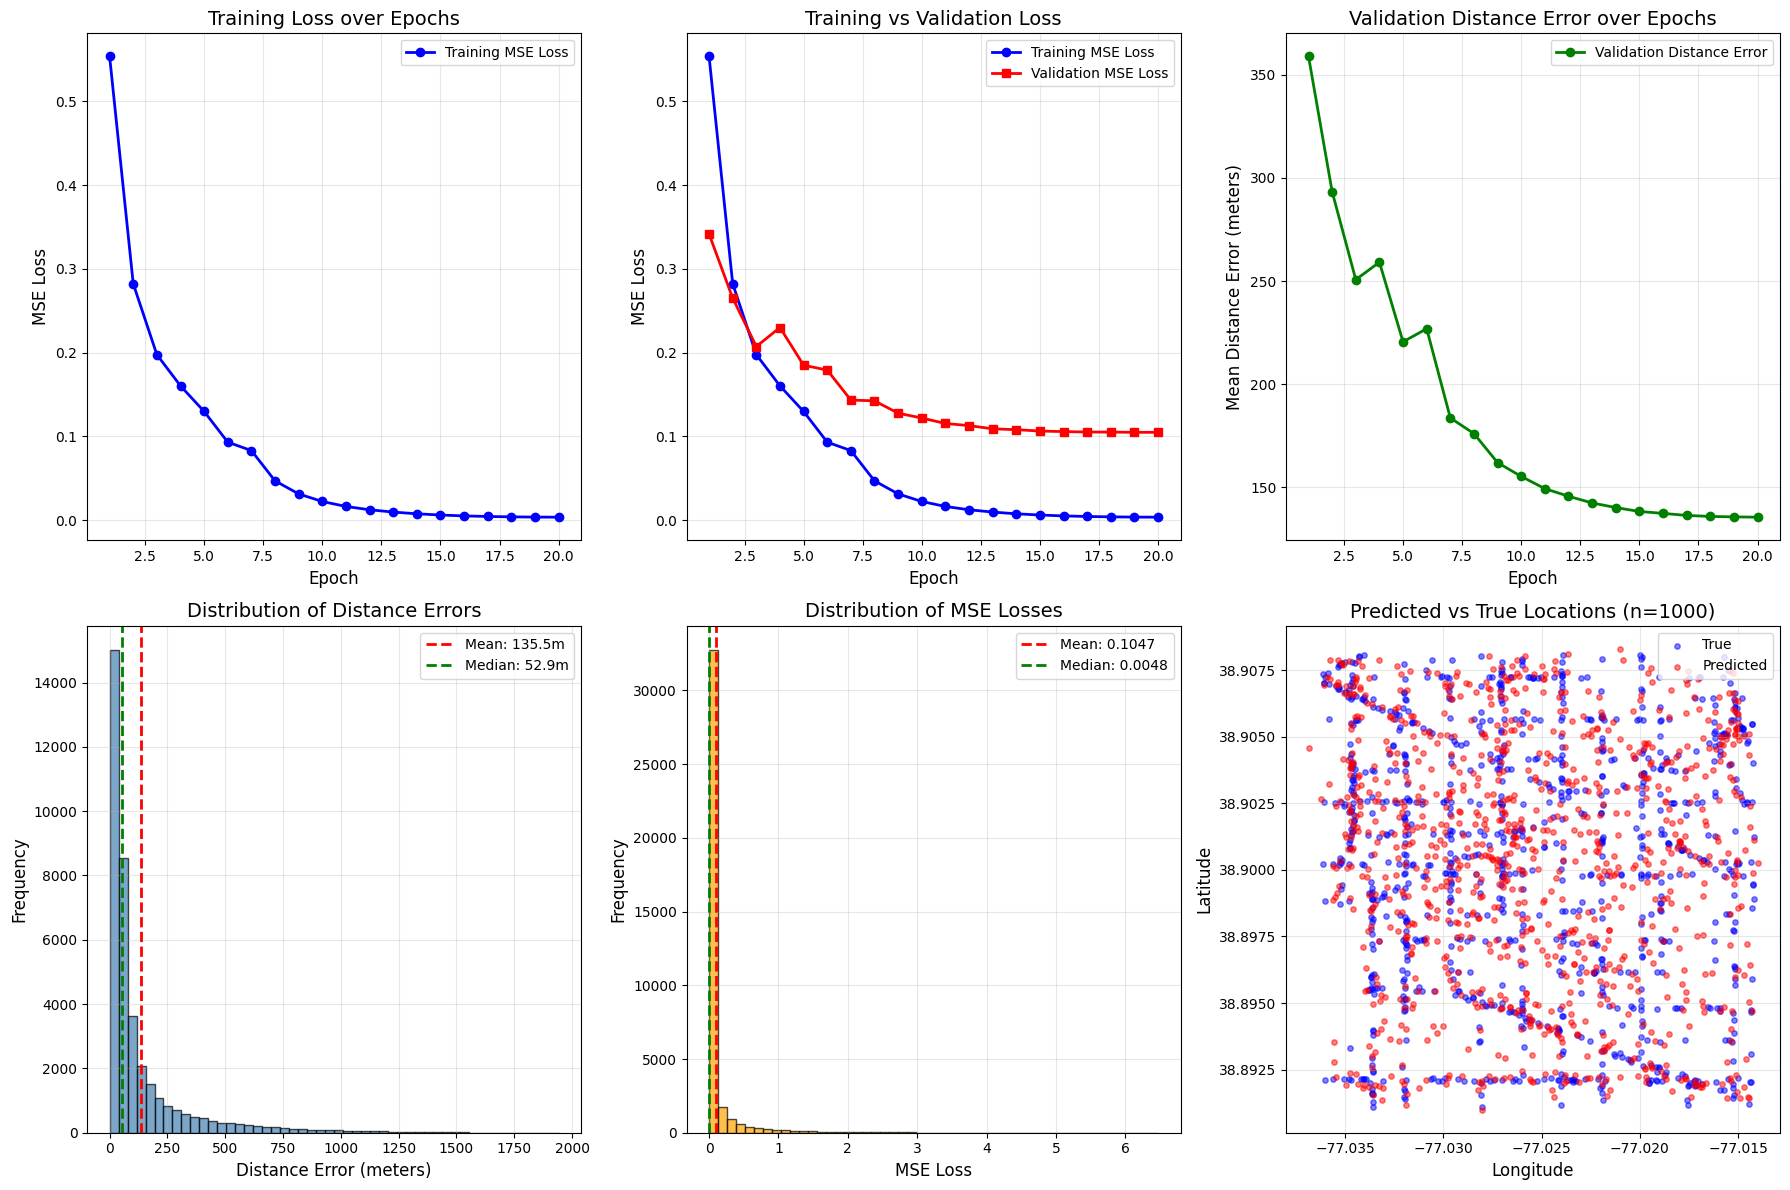


Results saved to 'regression_results.png'


In [8]:
# Visualization of Training Results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

epochs_range = range(1, len(train_losses) + 1)

# Plot 1: Training Loss Curve
ax1 = axes[0, 0]
ax1.plot(epochs_range, train_losses, 'b-o', label='Training MSE Loss', linewidth=2, markersize=6)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('MSE Loss', fontsize=12)
ax1.set_title('Training Loss over Epochs', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Training vs Validation Loss
ax2 = axes[0, 1]
ax2.plot(epochs_range, train_losses, 'b-o', label='Training MSE Loss', linewidth=2, markersize=6)
ax2.plot(epochs_range, val_losses, 'r-s', label='Validation MSE Loss', linewidth=2, markersize=6)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('MSE Loss', fontsize=12)
ax2.set_title('Training vs Validation Loss', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Validation Distance Error over Epochs
ax3 = axes[0, 2]
ax3.plot(epochs_range, val_distances, 'g-o', label='Validation Distance Error', linewidth=2, markersize=6)
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Mean Distance Error (meters)', fontsize=12)
ax3.set_title('Validation Distance Error over Epochs', fontsize=14)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Histogram of Distance Errors
ax4 = axes[1, 0]
ax4.hist(all_distances, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax4.axvline(mean_distance, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_distance:.1f}m')
ax4.axvline(median_distance, color='g', linestyle='--', linewidth=2, label=f'Median: {median_distance:.1f}m')
ax4.set_xlabel('Distance Error (meters)', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.set_title('Distribution of Distance Errors', fontsize=14)
ax4.legend()
ax4.grid(True, alpha=0.3)

# Plot 5: Histogram of MSE Losses
ax5 = axes[1, 1]
ax5.hist(all_losses, bins=50, edgecolor='black', alpha=0.7, color='orange')
ax5.axvline(mean_loss, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_loss:.4f}')
ax5.axvline(median_loss, color='g', linestyle='--', linewidth=2, label=f'Median: {median_loss:.4f}')
ax5.set_xlabel('MSE Loss', fontsize=12)
ax5.set_ylabel('Frequency', fontsize=12)
ax5.set_title('Distribution of MSE Losses', fontsize=14)
ax5.legend()
ax5.grid(True, alpha=0.3)

# Plot 6: Predicted vs Actual Locations (Scatter Plot)
ax6 = axes[1, 2]
sample_size = min(1000, len(all_predictions))
idx = np.random.choice(len(all_predictions), sample_size, replace=False)

ax6.scatter(all_targets[idx, 1], all_targets[idx, 0], alpha=0.5, s=15, label='True', c='blue')
ax6.scatter(all_predictions[idx, 1], all_predictions[idx, 0], alpha=0.5, s=15, label='Predicted', c='red')
ax6.set_xlabel('Longitude', fontsize=12)
ax6.set_ylabel('Latitude', fontsize=12)
ax6.set_title(f'Predicted vs True Locations (n={sample_size})', fontsize=14)
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('regression_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nResults saved to 'regression_results.png'")

Sample Predictions:


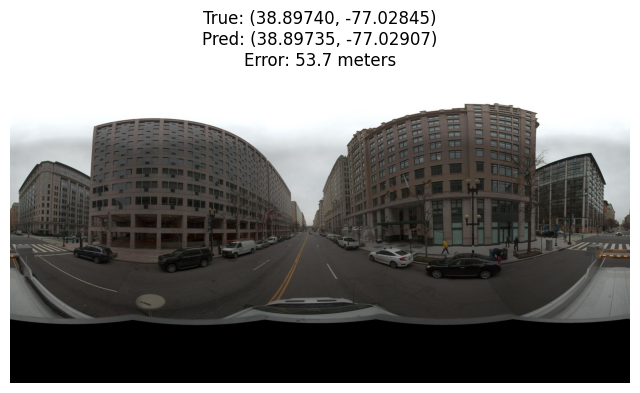

Sample 1: Distance error = 53.68 meters



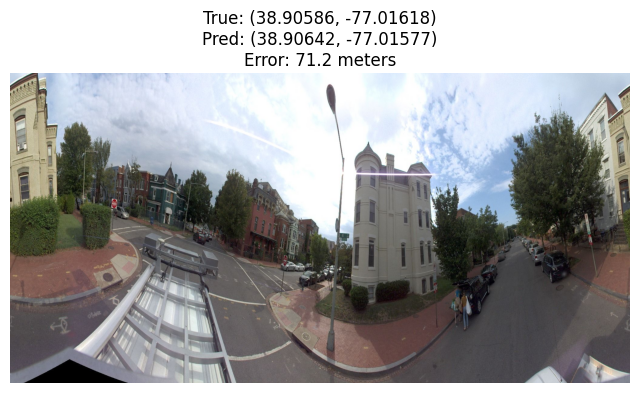

Sample 2: Distance error = 71.18 meters



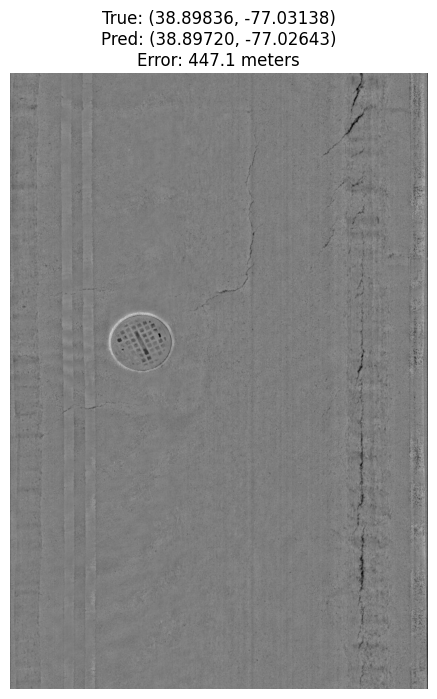

Sample 3: Distance error = 447.15 meters



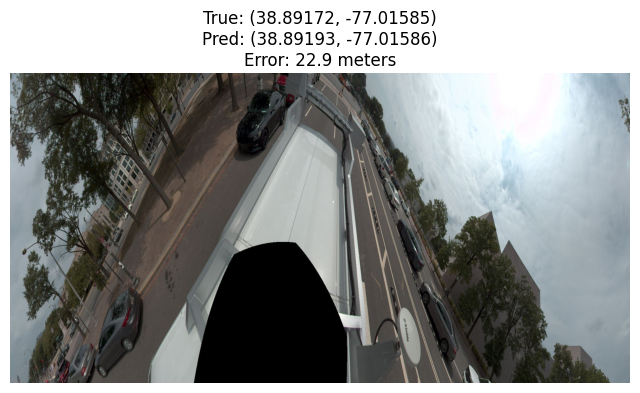

Sample 4: Distance error = 22.91 meters



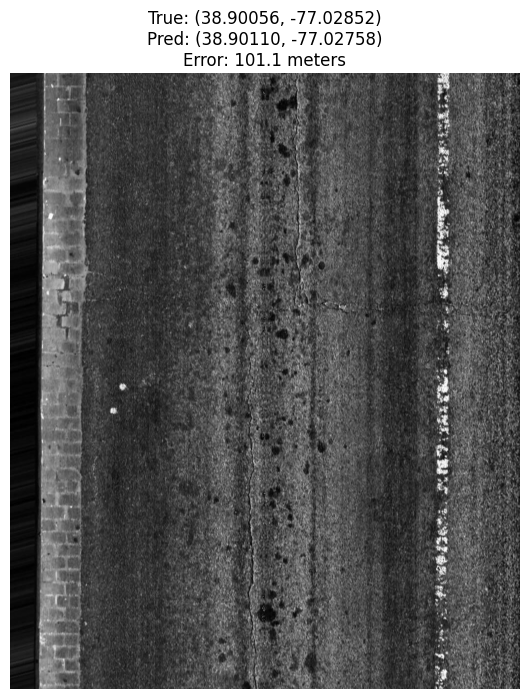

Sample 5: Distance error = 101.06 meters



In [9]:
# Visualize some individual predictions
def show_prediction(model, dataset, idx, transform, norm_params, device):
    """Show an image with its true and predicted coordinates."""
    model.eval()
    
    image, coords_norm = dataset[idx]
    
    # Get prediction
    with torch.no_grad():
        image_batch = image.unsqueeze(0).to(device)
        image_batch = transform(image_batch)
        output = model(image_batch)
    
    # Denormalize
    pred_lat = output[0, 0].item() * norm_params['lat_std'] + norm_params['lat_mean']
    pred_lon = output[0, 1].item() * norm_params['lon_std'] + norm_params['lon_mean']
    true_lat = coords_norm[0].item() * norm_params['lat_std'] + norm_params['lat_mean']
    true_lon = coords_norm[1].item() * norm_params['lon_std'] + norm_params['lon_mean']
    
    # Calculate distance
    dlat_m = (pred_lat - true_lat) * METERS_PER_DEG_LAT
    dlon_m = (pred_lon - true_lon) * METERS_PER_DEG_LON
    dist = np.sqrt(dlat_m**2 + dlon_m**2)
    
    # Display
    img_path = os.path.join("../../", dataset.img_labels.iloc[idx].loc["path"])
    img = Image.open(img_path).convert("RGB")
    
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f"True: ({true_lat:.5f}, {true_lon:.5f})\n"
              f"Pred: ({pred_lat:.5f}, {pred_lon:.5f})\n"
              f"Error: {dist:.1f} meters", fontsize=12)
    plt.axis("off")
    plt.show()
    
    return dist

# Show 5 random predictions
print("Sample Predictions:")
print("=" * 50)
for i in range(5):
    idx = np.random.randint(0, len(test_data))
    dist = show_prediction(model, test_data, idx, transform, norm_params, device)
    print(f"Sample {i+1}: Distance error = {dist:.2f} meters\n")

In [ ]:
# Additional Analysis: Error by geographic region
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Error magnitude on a map (color-coded scatter)
ax1 = axes[0]
scatter = ax1.scatter(all_targets[:, 1], all_targets[:, 0], 
                       c=all_distances, cmap='RdYlGn_r', alpha=0.6, s=10,
                       vmin=0, vmax=np.percentile(all_distances, 95))
plt.colorbar(scatter, ax=ax1, label='Distance Error (meters)')
ax1.set_xlabel('Longitude', fontsize=12)
ax1.set_ylabel('Latitude', fontsize=12)
ax1.set_title('Prediction Error by Location', fontsize=14)
ax1.grid(True, alpha=0.3)

# Plot 2: Error vectors (showing direction of prediction errors)
ax2 = axes[1]
sample_size = min(500, len(all_predictions))
idx = np.random.choice(len(all_predictions), sample_size, replace=False)

# Draw arrows from true to predicted locations
for i in idx:
    ax2.annotate('', xy=(all_predictions[i, 1], all_predictions[i, 0]),
                 xytext=(all_targets[i, 1], all_targets[i, 0]),
                 arrowprops=dict(arrowstyle='->', color='red', alpha=0.3, lw=0.5))

ax2.scatter(all_targets[idx, 1], all_targets[idx, 0], c='blue', s=10, alpha=0.5, label='True')
ax2.set_xlabel('Longitude', fontsize=12)
ax2.set_ylabel('Latitude', fontsize=12)
ax2.set_title(f'Prediction Error Vectors (n={sample_size})', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nError analysis saved to 'error_analysis.png'")